In [1]:
# Imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

### Vizulaize Data Sample

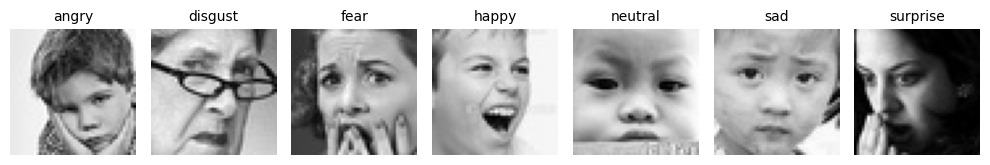

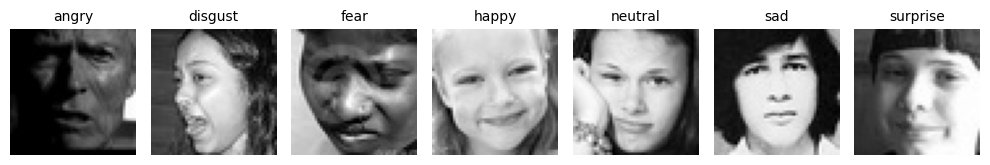

In [6]:
# Define directories
train_data_dir = 'fer2013/train'
test_data_dir = 'fer2013/test'

# Function to display an image from each folder
def display_images_from_folder(directory):
    # Get all subfolders in the directory
    subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    cols = len(subfolders)
    plt.figure(figsize=(10, 10))
    
    index = 1
    for folder in subfolders:
        folder_path = os.path.join(directory, folder)
        # Get a list of all images in the folder
        image_files = os.listdir(folder_path)
        image_path = os.path.join(folder_path, random.choice(image_files))
        
        # Open the image using PIL and convert to grayscale
        img = Image.open(image_path).convert('L')
        img = np.array(img)  # Convert the image to a NumPy array
        
        # Plot the image
        plt.subplot(1, cols, index)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(folder, fontsize=10)
        plt.axis('off')
        index += 1

    # Display the figure with all the images
    plt.tight_layout() # Adjust spacing between subplots
    plt.show()

# Display images from each directory
display_images_from_folder(train_data_dir)
display_images_from_folder(test_data_dir)

### Data Loading and Pre Processing

In [7]:
BATCH_SIZE = 64
INPUT_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=None, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=None)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

def preprocess_fer2013(image):
    # Convert grayscale image to RGB by repeating the single channel across 3 channels
    image = np.repeat(image[..., np.newaxis], 3, axis=-1)  # Correctly expand to (224, 224, 3)
    return image

preprocessing_function = preprocess_fer2013

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Load Base Model for Transfer Learning

In [8]:
# Load the base model
base_model = load_model('face_detection.h5', compile=False)

base_model.summary()

net_description = 'identified_face' # checkpoints

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)          │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 225, 225, 3)       │               0 │ input_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1 (DepthwiseConv2D)   │ (None, 112, 112, 32)      │             288 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1_bn                  │ (None, 112, 112, 32)      │             128 │ conv_dw_1[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_1_relu (ReLU)         │ (None, 112, 112, 32)      │               0 │ conv_dw_1_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1 (Conv2D)            │ (None, 112, 112, 64)      │           2,048 │ conv_dw_1_relu[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1_bn                  │ (None, 112, 112, 64)      │             256 │ conv_pw_1[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_1_relu (ReLU)         │ (None, 112, 112, 64)      │               0 │ conv_pw_1_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pad_2 (ZeroPadding2D)    │ (None, 113, 113, 64)      │               0 │ conv_pw_1_relu[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2 (DepthwiseConv2D)   │ (None, 56, 56, 64)        │             576 │ conv_pad_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2_bn                  │ (None, 56, 56, 64)        │             256 │ conv_dw_2[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_dw_2_relu (ReLU)         │ (None, 56, 56, 64)        │               0 │ conv_dw_2_bn[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_pw_2 (Conv2D)            │ (None, 56, 56, 128)       │           8,19

 Total params: 3,517,221 (13.42 MB)

 Trainable params: 3,495,333 (13.33 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [9]:
# Get the list of layers in the model
layers = base_model.layers

# Display the last 20 layers and their details
print("\nLast 20 layers details:")
for layer in layers[-20:]:
    print(f"Layer Name: {layer.name}")
    print(f"Layer Type: {layer.__class__.__name__}")

    # Check if the layer has an output shape before accessing it
    if hasattr(layer, 'output_shape'):
        print(f"Output Shape: {layer.output_shape}")
    
    # Check if the layer has trainable parameters
    if hasattr(layer, 'count_params'):
        print(f"Number of Parameters: {layer.count_params()}")

    print("-" * 50)


Last 20 layers details:
Layer Name: conv_pw_11_relu
Layer Type: ReLU
Number of Parameters: 0
--------------------------------------------------
Layer Name: conv_pad_12
Layer Type: ZeroPadding2D
Number of Parameters: 0
--------------------------------------------------
Layer Name: conv_dw_12
Layer Type: DepthwiseConv2D
Number of Parameters: 4608
--------------------------------------------------
Layer Name: conv_dw_12_bn
Layer Type: BatchNormalization
Number of Parameters: 2048
--------------------------------------------------
Layer Name: conv_dw_12_relu
Layer Type: ReLU
Number of Parameters: 0
--------------------------------------------------
Layer Name: conv_pw_12
Layer Type: Conv2D
Number of Parameters: 524288
--------------------------------------------------
Layer Name: conv_pw_12_bn
Layer Type: BatchNormalization
Number of Parameters: 4096
--------------------------------------------------
Layer Name: conv_pw_12_relu
Layer Type: ReLU
Number of Parameters: 0
--------------------

### Adjuzting the Model

In [10]:
# Removing the last layers
# Extracting up to the layer before `dropout_2`
output_layer = base_model.get_layer('feats').output

# Add new dense layer for emotion predictions
emotion_preds = Dense(7, activation='softmax', name='emotion_preds')(output_layer)

# Create the new model
model = Model(inputs=base_model.input, outputs=emotion_preds, name="model_2")

# Compile the new model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the updated model
model.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)                 │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_pad (ZeroPadding2D)            │ (None, 225, 225, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,493,063 (13.32 MB)

 Trainable params: 3,471,175 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [11]:
# Get the final layer in the model
final_layer = model.layers[-1]

# Display the final layer details
print(f"Layer Name: {final_layer.name}")
print(f"Layer Type: {final_layer.__class__.__name__}")

# Use .output.shape to get the output shape safely
if hasattr(final_layer, 'output'):
    print(f"Output Shape: {final_layer.output.shape}")

# Print the number of parameters
if hasattr(final_layer, 'count_params'):
    print(f"Number of Parameters: {final_layer.count_params()}")


Layer Name: emotion_preds
Layer Type: Dense
Output Shape: (None, 7)
Number of Parameters: 1799


In [12]:
# Initial Parameters Setup
N_CLASS=test_generator.num_classes
nb_train_samples=train_generator.samples
nb_test_samples=test_generator.samples
print(N_CLASS,nb_train_samples,nb_test_samples)

7 28709 7178


In [13]:
# Mapping Class Indices to Class Labels
class_to_idx=test_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [14]:
# Calculating Class Weights (balance the classes that are underrepresented)
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, test_generator.class_indices)

[3995  436 4097 7215 4965 4830 3171] {np.int32(0): np.float64(1.8060075093867334), np.int32(1): np.float64(16.54816513761468), np.int32(2): np.float64(1.7610446668293875), np.int32(3): np.float64(1.0), np.int32(4): np.float64(1.4531722054380665), np.int32(5): np.float64(1.4937888198757765), np.int32(6): np.float64(2.275307473982971)} {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'} {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [16]:
start_epoch=0

# Freez the base model
base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
    
# Compiling the Model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#Callbacks
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy',patience=10)

FIRST_EPOCHS=10

print(model.input_shape)

(None, 224, 224, 3)


In [17]:
# Start training
hist1=model.fit(
    train_generator, 
    steps_per_epoch=nb_train_samples//BATCH_SIZE, 
    epochs=FIRST_EPOCHS, verbose=1, 
    initial_epoch=0, 
    callbacks=[mc, es], 
    validation_data=test_generator, 
    validation_steps=nb_test_samples // BATCH_SIZE,
    class_weight=class_weights
    )

Epoch 1/10


C:\Users\Thisalka Mihisara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.2234 - loss: 3.4715
Epoch 1: val_accuracy improved from -inf to 0.33161, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 420s 933ms/step - accuracy: 0.2234 - loss: 3.4711 - val_accuracy: 0.3316 - val_loss: 1.7474
Epoch 2/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:38 757ms/step - accuracy: 0.3125 - loss: 4.4828

C:\Users\Thisalka Mihisara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.33161
448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 189ms/step - accuracy: 0.3125 - loss: 4.4828 - val_accuracy: 0.3308 - val_loss: 1.7477
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.3170 - loss: 3.1157
Epoch 3: val_accuracy did not improve from 0.33161
448/448 ━━━━━━━━━━━━━━━━━━━━ 423s 945ms/step - accuracy: 0.3170 - loss: 3.1156 - val_accuracy: 0.3036 - val_loss: 1.7661
Epoch 4/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:39 760ms/step - accuracy: 0.3438 - loss: 2.6855
Epoch 4: val_accuracy did not improve from 0.33161
448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - accuracy: 0.3438 - loss: 2.6855 - val_accuracy: 0.3043 - val_loss: 1.7643
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.3324 - loss: 2.9998
Epoch 5: val_accuracy improved from 0.33161 to 0.33189, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 423s 945ms/step - accuracy: 0.3324 - loss: 2.9998 - val_accuracy: 0.3319 - val_loss: 1.7251
Epoch 6/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:46 774ms/step - accuracy: 0.2344 - loss: 3.1170
Epoch 6: val_accuracy improved from 0.33189 to 0.33287, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 87s 194ms/step - accuracy: 0.2344 - loss: 3.1170 - val_accuracy: 0.3329 - val_loss: 1.7250
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.3344 - loss: 3.0095
Epoch 7: val_accuracy improved from 0.33287 to 0.33845, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 423s 945ms/step - accuracy: 0.3344 - loss: 3.0095 - val_accuracy: 0.3384 - val_loss: 1.6981
Epoch 8/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:44 771ms/step - accuracy: 0.3594 - loss: 2.7208
Epoch 8: val_accuracy improved from 0.33845 to 0.34012, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - accuracy: 0.3594 - loss: 2.7208 - val_accuracy: 0.3401 - val_loss: 1.6972
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.3460 - loss: 2.9810
Epoch 9: val_accuracy improved from 0.34012 to 0.35059, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 426s 952ms/step - accuracy: 0.3460 - loss: 2.9810 - val_accuracy: 0.3506 - val_loss: 1.6842
Epoch 10/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:34 748ms/step - accuracy: 0.2656 - loss: 2.5799
Epoch 10: val_accuracy improved from 0.35059 to 0.35086, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 190ms/step - accuracy: 0.2656 - loss: 2.5799 - val_accuracy: 0.3509 - val_loss: 1.6840


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint

# Get the current training epoch
start_epoch = len(hist1.history['loss'])

# Unfreeze the last few layers (top 5 layers) 
for layer in base_model.layers[-5:]: 
    layer.trainable = True

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,  # Adjust decay steps based on dataset size
    decay_rate=0.96,  # Decay factor
    staircase=True
)

# Compile the model with corrected optimizer
model.load_weights(net_description + '_ft.h5')
model.compile(optimizer=Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define new total epochs
SECOND_EPOCHS = start_epoch + 25

# Model checkpoint to save the best model
mc = ModelCheckpoint(net_description + '_ft.h5', 
                     monitor='val_accuracy', 
                     verbose=1, 
                     save_best_only=True)

# Train the model
hist2 = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=SECOND_EPOCHS, 
    verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=test_generator, 
    validation_steps=test_generator.samples // BATCH_SIZE, 
    callbacks=[mc], 
    class_weight=class_weights
)


Epoch 11/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.3738 - loss: 2.9498
Epoch 11: val_accuracy improved from -inf to 0.44043, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 433s 963ms/step - accuracy: 0.3738 - loss: 2.9496 - val_accuracy: 0.4404 - val_loss: 1.5223
Epoch 12/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:59 805ms/step - accuracy: 0.4531 - loss: 2.7631
Epoch 12: val_accuracy did not improve from 0.44043
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - accuracy: 0.4531 - loss: 2.7631 - val_accuracy: 0.4402 - val_loss: 1.5220
Epoch 13/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.4348 - loss: 2.6661
Epoch 13: val_accuracy improved from 0.44043 to 0.49163, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 430s 960ms/step - accuracy: 0.4348 - loss: 2.6660 - val_accuracy: 0.4916 - val_loss: 1.3916
Epoch 14/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:37 754ms/step - accuracy: 0.3750 - loss: 2.3645
Epoch 14: val_accuracy improved from 0.49163 to 0.49275, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - accuracy: 0.3750 - loss: 2.3645 - val_accuracy: 0.4927 - val_loss: 1.3912
Epoch 15/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.4733 - loss: 2.5000
Epoch 15: val_accuracy improved from 0.49275 to 0.50949, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 426s 952ms/step - accuracy: 0.4733 - loss: 2.4999 - val_accuracy: 0.5095 - val_loss: 1.3426
Epoch 16/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:39 760ms/step - accuracy: 0.4062 - loss: 2.9565
Epoch 16: val_accuracy improved from 0.50949 to 0.50963, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 87s 193ms/step - accuracy: 0.4062 - loss: 2.9565 - val_accuracy: 0.5096 - val_loss: 1.3419
Epoch 17/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.4974 - loss: 2.3849
Epoch 17: val_accuracy improved from 0.50963 to 0.52595, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 441s 985ms/step - accuracy: 0.4974 - loss: 2.3849 - val_accuracy: 0.5259 - val_loss: 1.2977
Epoch 18/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:26 731ms/step - accuracy: 0.5625 - loss: 2.3428
Epoch 18: val_accuracy did not improve from 0.52595
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - accuracy: 0.5625 - loss: 2.3428 - val_accuracy: 0.5258 - val_loss: 1.2990
Epoch 19/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.5143 - loss: 2.3045
Epoch 19: val_accuracy did not improve from 0.52595
448/448 ━━━━━━━━━━━━━━━━━━━━ 426s 952ms/step - accuracy: 0.5143 - loss: 2.3045 - val_accuracy: 0.5212 - val_loss: 1.3025
Epoch 20/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:54 792ms/step - accuracy: 0.6406 - loss: 2.2113
Epoch 20: val_accuracy did not improve from 0.52595
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - accuracy: 0.6406 - loss: 2.2113 - val_accuracy: 0.5213 - val_loss: 1.3033
Epoch 21/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.5124 - loss: 2.2873
Ep

448/448 ━━━━━━━━━━━━━━━━━━━━ 425s 950ms/step - accuracy: 0.5124 - loss: 2.2873 - val_accuracy: 0.5479 - val_loss: 1.2457
Epoch 22/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:31 742ms/step - accuracy: 0.5781 - loss: 1.9962
Epoch 22: val_accuracy did not improve from 0.54785
448/448 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.5781 - loss: 1.9962 - val_accuracy: 0.5473 - val_loss: 1.2455
Epoch 23/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5265 - loss: 2.2492
Epoch 23: val_accuracy improved from 0.54785 to 0.55246, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 423s 945ms/step - accuracy: 0.5265 - loss: 2.2492 - val_accuracy: 0.5525 - val_loss: 1.2289
Epoch 24/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:41 764ms/step - accuracy: 0.5625 - loss: 1.8171
Epoch 24: val_accuracy improved from 0.55246 to 0.55287, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 189ms/step - accuracy: 0.5625 - loss: 1.8171 - val_accuracy: 0.5529 - val_loss: 1.2276
Epoch 25/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.5327 - loss: 2.2215
Epoch 25: val_accuracy did not improve from 0.55287
448/448 ━━━━━━━━━━━━━━━━━━━━ 422s 942ms/step - accuracy: 0.5327 - loss: 2.2215 - val_accuracy: 0.5435 - val_loss: 1.2508
Epoch 26/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:54 793ms/step - accuracy: 0.5312 - loss: 1.9555
Epoch 26: val_accuracy did not improve from 0.55287
448/448 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - accuracy: 0.5312 - loss: 1.9555 - val_accuracy: 0.5438 - val_loss: 1.2503
Epoch 27/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.5316 - loss: 2.2058
Epoch 27: val_accuracy did not improve from 0.55287
448/448 ━━━━━━━━━━━━━━━━━━━━ 427s 954ms/step - accuracy: 0.5316 - loss: 2.2058 - val_accuracy: 0.5520 - val_loss: 1.2277
Epoch 28/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:53 790ms/step - accuracy: 0.4844 - loss: 2.8176
Ep

448/448 ━━━━━━━━━━━━━━━━━━━━ 426s 952ms/step - accuracy: 0.5447 - loss: 2.1472 - val_accuracy: 0.5688 - val_loss: 1.1880
Epoch 32/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:44 771ms/step - accuracy: 0.4688 - loss: 2.4234
Epoch 32: val_accuracy did not improve from 0.56878
448/448 ━━━━━━━━━━━━━━━━━━━━ 87s 192ms/step - accuracy: 0.4688 - loss: 2.4234 - val_accuracy: 0.5688 - val_loss: 1.1879
Epoch 33/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.5510 - loss: 2.0908
Epoch 33: val_accuracy did not improve from 0.56878
448/448 ━━━━━━━━━━━━━━━━━━━━ 446s 997ms/step - accuracy: 0.5510 - loss: 2.0909 - val_accuracy: 0.5657 - val_loss: 1.1965
Epoch 34/35
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:53 790ms/step - accuracy: 0.5156 - loss: 2.4274
Epoch 34: val_accuracy did not improve from 0.56878
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 197ms/step - accuracy: 0.5156 - loss: 2.4274 - val_accuracy: 0.5656 - val_loss: 1.1963
Epoch 35/35
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.5509 - loss: 2.1133
Ep

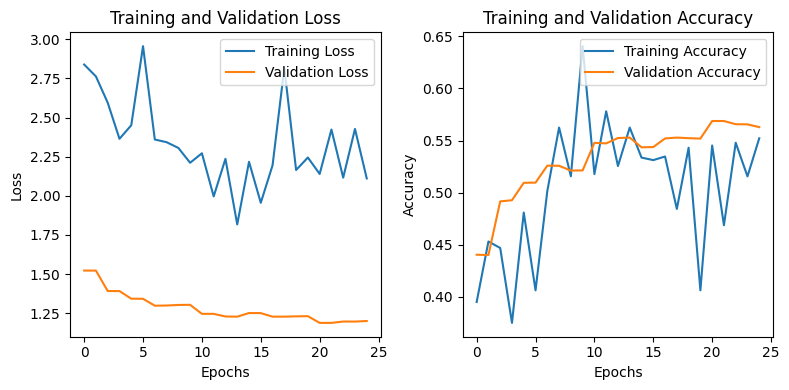

In [21]:
# Extracting training and validation loss and accuracy from history
history = hist2.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.optimizers import Adam

# Get the start epoch from the second training phase
start_epoch = len(hist2.history['loss'])

# Unfreeze all layers for fine-tuning
for l in base_model.layers:
    l.trainable = True

# Load pre-trained weights
model.load_weights(net_description + '_ft.h5')

# Corrected Adam optimizer (No `lr`, No `decay`)
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Use `learning_rate`
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:

SECOND_EPOCHS=start_epoch+65
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

hist3=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=test_generator, 
    validation_steps=test_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 26/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5560 - loss: 2.1606
Epoch 26: val_accuracy improved from -inf to 0.61900, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2178s 5s/step - accuracy: 0.5560 - loss: 2.1603 - val_accuracy: 0.6190 - val_loss: 1.0553
Epoch 27/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:16 5s/step - accuracy: 0.6250 - loss: 1.9122
Epoch 27: val_accuracy did not improve from 0.61900
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - accuracy: 0.6250 - loss: 1.9122 - val_accuracy: 0.6187 - val_loss: 1.0555
Epoch 28/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6242 - loss: 1.7740
Epoch 28: val_accuracy improved from 0.61900 to 0.62779, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2171s 5s/step - accuracy: 0.6243 - loss: 1.7739 - val_accuracy: 0.6278 - val_loss: 1.0217
Epoch 29/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:44 5s/step - accuracy: 0.4844 - loss: 1.7517
Epoch 29: val_accuracy improved from 0.62779 to 0.62821, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 93s 197ms/step - accuracy: 0.4844 - loss: 1.7517 - val_accuracy: 0.6282 - val_loss: 1.0189
Epoch 30/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6532 - loss: 1.5712
Epoch 30: val_accuracy improved from 0.62821 to 0.65402, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2172s 5s/step - accuracy: 0.6532 - loss: 1.5712 - val_accuracy: 0.6540 - val_loss: 0.9592
Epoch 31/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:34 5s/step - accuracy: 0.8281 - loss: 1.1262
Epoch 31: val_accuracy improved from 0.65402 to 0.65499, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - accuracy: 0.8281 - loss: 1.1262 - val_accuracy: 0.6550 - val_loss: 0.9583
Epoch 32/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6870 - loss: 1.4106
Epoch 32: val_accuracy improved from 0.65499 to 0.66169, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2170s 5s/step - accuracy: 0.6870 - loss: 1.4106 - val_accuracy: 0.6617 - val_loss: 0.9516
Epoch 33/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:31 5s/step - accuracy: 0.7500 - loss: 1.4176
Epoch 33: val_accuracy did not improve from 0.66169
448/448 ━━━━━━━━━━━━━━━━━━━━ 90s 191ms/step - accuracy: 0.7500 - loss: 1.4176 - val_accuracy: 0.6609 - val_loss: 0.9529
Epoch 34/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7059 - loss: 1.3098
Epoch 34: val_accuracy improved from 0.66169 to 0.67160, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2172s 5s/step - accuracy: 0.7059 - loss: 1.3099 - val_accuracy: 0.6716 - val_loss: 0.9172
Epoch 35/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:13 5s/step - accuracy: 0.7188 - loss: 1.1971
Epoch 35: val_accuracy did not improve from 0.67160
448/448 ━━━━━━━━━━━━━━━━━━━━ 90s 192ms/step - accuracy: 0.7188 - loss: 1.1971 - val_accuracy: 0.6713 - val_loss: 0.9186
Epoch 36/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7261 - loss: 1.2137
Epoch 36: val_accuracy did not improve from 0.67160
448/448 ━━━━━━━━━━━━━━━━━━━━ 2171s 5s/step - accuracy: 0.7261 - loss: 1.2137 - val_accuracy: 0.6678 - val_loss: 0.9380
Epoch 37/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:37 5s/step - accuracy: 0.7188 - loss: 1.0358
Epoch 37: val_accuracy did not improve from 0.67160
448/448 ━━━━━━━━━━━━━━━━━━━━ 90s 191ms/step - accuracy: 0.7188 - loss: 1.0358 - val_accuracy: 0.6688 - val_loss: 0.9370
Epoch 38/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7389 - loss: 1.1483
Epoch 38: val_ac

448/448 ━━━━━━━━━━━━━━━━━━━━ 2176s 5s/step - accuracy: 0.7389 - loss: 1.1484 - val_accuracy: 0.6848 - val_loss: 0.9009
Epoch 39/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:14 5s/step - accuracy: 0.6875 - loss: 1.2590
Epoch 39: val_accuracy did not improve from 0.68485
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.6875 - loss: 1.2590 - val_accuracy: 0.6842 - val_loss: 0.9018
Epoch 40/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7608 - loss: 1.0499
Epoch 40: val_accuracy improved from 0.68485 to 0.69001, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2173s 5s/step - accuracy: 0.7608 - loss: 1.0499 - val_accuracy: 0.6900 - val_loss: 0.8915
Epoch 41/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:44 5s/step - accuracy: 0.6562 - loss: 1.2750
Epoch 41: val_accuracy did not improve from 0.69001
448/448 ━━━━━━━━━━━━━━━━━━━━ 90s 191ms/step - accuracy: 0.6562 - loss: 1.2750 - val_accuracy: 0.6900 - val_loss: 0.8920
Epoch 42/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7752 - loss: 0.9983
Epoch 42: val_accuracy did not improve from 0.69001
448/448 ━━━━━━━━━━━━━━━━━━━━ 2230s 5s/step - accuracy: 0.7752 - loss: 0.9983 - val_accuracy: 0.6853 - val_loss: 0.9307
Epoch 43/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:20 5s/step - accuracy: 0.7656 - loss: 1.0330
Epoch 43: val_accuracy did not improve from 0.69001
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.7656 - loss: 1.0330 - val_accuracy: 0.6864 - val_loss: 0.9299
Epoch 44/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7958 - loss: 0.9071
Epoch 44: val_ac

448/448 ━━━━━━━━━━━━━━━━━━━━ 2154s 5s/step - accuracy: 0.8244 - loss: 0.7769 - val_accuracy: 0.6942 - val_loss: 0.9756
Epoch 49/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:57 5s/step - accuracy: 0.8750 - loss: 0.6008
Epoch 49: val_accuracy did not improve from 0.69420
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 192ms/step - accuracy: 0.8750 - loss: 0.6008 - val_accuracy: 0.6932 - val_loss: 0.9804
Epoch 50/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8473 - loss: 0.6885
Epoch 50: val_accuracy improved from 0.69420 to 0.69992, saving model to identified_face_ft.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2164s 5s/step - accuracy: 0.8473 - loss: 0.6885 - val_accuracy: 0.6999 - val_loss: 0.9961
Epoch 51/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:18 5s/step - accuracy: 0.8125 - loss: 0.7289
Epoch 51: val_accuracy did not improve from 0.69992
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 193ms/step - accuracy: 0.8125 - loss: 0.7289 - val_accuracy: 0.6994 - val_loss: 0.9964
Epoch 52/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8656 - loss: 0.6186
Epoch 52: val_accuracy did not improve from 0.69992
448/448 ━━━━━━━━━━━━━━━━━━━━ 2169s 5s/step - accuracy: 0.8655 - loss: 0.6186 - val_accuracy: 0.6833 - val_loss: 1.0760
Epoch 53/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:19 5s/step - accuracy: 0.7188 - loss: 1.0726
Epoch 53: val_accuracy did not improve from 0.69992
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 193ms/step - accuracy: 0.7188 - loss: 1.0726 - val_accuracy: 0.6836 - val_loss: 1.0778
Epoch 54/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8799 - loss: 0.5610
Epoch 54: val_ac

448/448 ━━━━━━━━━━━━━━━━━━━━ 2173s 5s/step - accuracy: 0.9187 - loss: 0.3975 - val_accuracy: 0.7034 - val_loss: 1.2540
Epoch 61/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:23 5s/step - accuracy: 0.9062 - loss: 0.3697
Epoch 61: val_accuracy did not improve from 0.70340
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - accuracy: 0.9062 - loss: 0.3697 - val_accuracy: 0.7024 - val_loss: 1.2533
Epoch 62/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9263 - loss: 0.3612
Epoch 62: val_accuracy did not improve from 0.70340
448/448 ━━━━━━━━━━━━━━━━━━━━ 2170s 5s/step - accuracy: 0.9263 - loss: 0.3612 - val_accuracy: 0.6889 - val_loss: 1.2695
Epoch 63/90
  1/448 ━━━━━━━━━━━━━━━━━━━━ 34:47 5s/step - accuracy: 0.9219 - loss: 0.4119
Epoch 63: val_accuracy did not improve from 0.70340
448/448 ━━━━━━━━━━━━━━━━━━━━ 91s 193ms/step - accuracy: 0.9219 - loss: 0.4119 - val_accuracy: 0.6875 - val_loss: 1.2684
Epoch 64/90
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9302 - loss: 0.3433
Epoch 64: val_ac

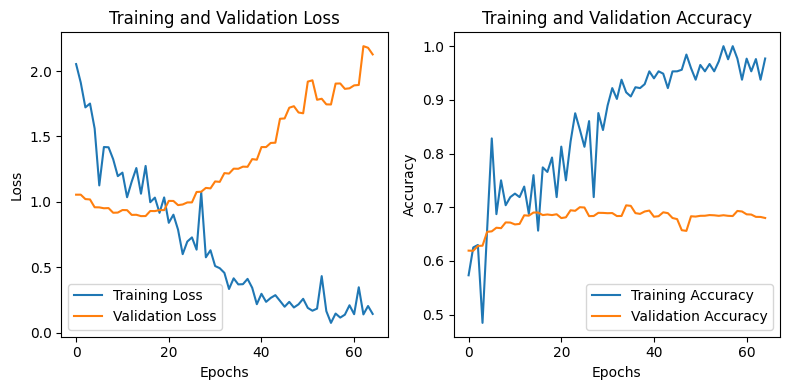

In [26]:
# Extracting training and validation loss and accuracy from history
history = hist3.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

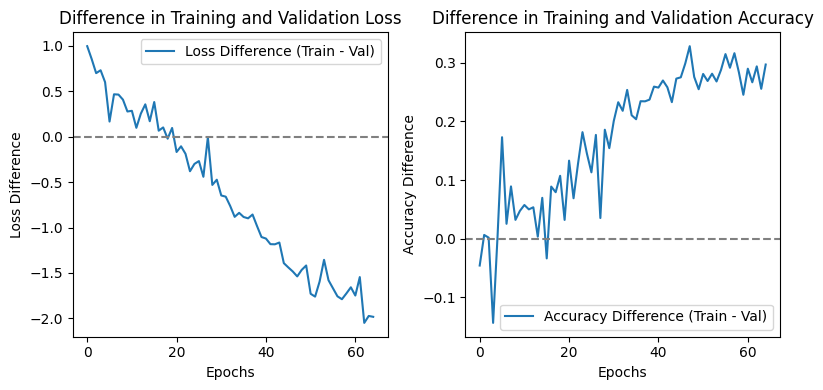

In [27]:
plt.figure(figsize=(8, 4))

# Difference between training and validation loss
plt.subplot(1, 2, 1)
loss_diff = np.array(history['loss']) - np.array(history['val_loss'])
plt.plot(loss_diff, label='Loss Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()

# Difference between training and validation accuracy
plt.subplot(1, 2, 2)
acc_diff = np.array(history['accuracy']) - np.array(history['val_accuracy'])
plt.plot(acc_diff, label='Accuracy Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()

plt.tight_layout()
plt.show()


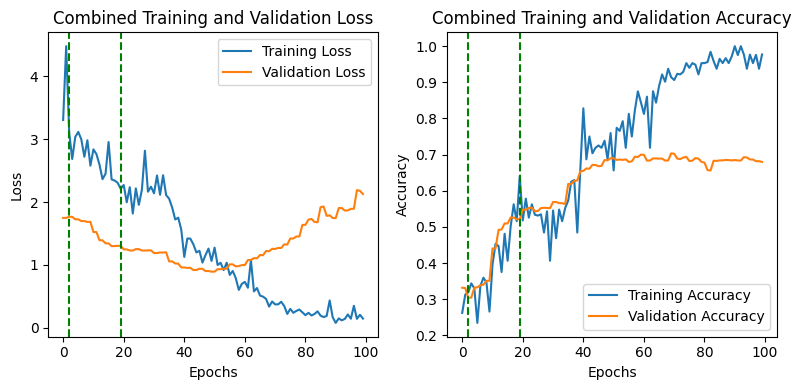

In [28]:

# Assuming hist1, hist2, hist3 are the history objects from the three training runs
history1 = hist1.history
history2 = hist2.history
history3 = hist3.history

# Combine the histories by concatenating loss and accuracy values
combined_loss = history1['loss'] + history2['loss'] + history3['loss']
combined_val_loss = history1['val_loss'] + history2['val_loss'] + history3['val_loss']
combined_accuracy = history1['accuracy'] + history2['accuracy'] + history3['accuracy']
combined_val_accuracy = history1['val_accuracy'] + history2['val_accuracy'] + history3['val_accuracy']

# Define the epoch num where it saved the best models (not the number of epochs)
change_point_1 = 2
change_point_2 = 19

# Create a plot for combined training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.axvline(x=change_point_1, color='g', linestyle='--', label='History Change')
plt.axvline(x=change_point_2, color='g', linestyle='--', label='History Change')


# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(combined_accuracy, label='Training Accuracy')
plt.plot(combined_val_accuracy, label='Validation Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.axvline(x=change_point_1, color='g', linestyle='--')
plt.axvline(x=change_point_2, color='g', linestyle='--')

# Show the plots
plt.tight_layout()
plt.show()


In [1]:

# Load trained model for facial emotion recognition
model_best = load_model('identified_face_ft.h5')  # Current best model

# Trained emotions:
class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Map Classes for the three emotional states
emotion_mapping = {
    'Anger': 'Confused', 
    'Disgust': 'Confused', 
    'Fear': 'Confused', 
    'Happiness': 'Happy', 
    'Neutral': 'Neutral', 
    'Sadness': 'Sad', 
    'Surprise': 'Confused'
}

image_folder = 'test/'  # folder path

# Initialize dictionaries to collect images for each mapped class
class_image_paths = {'Confused': [], 'Happy': [], 'Neutral': [], 'Sad': []}

# Collect image paths grouped by the mapped class
for label_folder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, label_folder)
    
    # Check if the folder is a directory and if the folder name is numeric
    if os.path.isdir(subfolder_path) and label_folder.isdigit():
        # Map the folder name to the corresponding emotion label
        emotion_label = class_names[int(label_folder)]
        mapped_emotion_label = emotion_mapping[emotion_label]

        # Get the list of image files in the subfolder
        image_files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        class_image_paths[mapped_emotion_label].extend(image_files)

#Determine the minimum number of images for any class
min_images = min(len(class_image_paths['Confused']), len(class_image_paths['Happy']),
                 len(class_image_paths['Neutral']), len(class_image_paths['Sad']))

# Limit each class to the same number of images (minimum count)
selected_image_paths = {key: random.sample(paths, min_images) for key, paths in class_image_paths.items()}

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Process selected images
for class_name, image_paths in selected_image_paths.items():
    for img_path in image_paths:
        # Load the image
        img = cv2.imread(img_path)

        # Resize the face image to the required input size for the model
        face_image = cv2.resize(img, (224, 224))  # Change to 224x224
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)  # Convert to RGB (if BGR)
        face_image = image.img_to_array(face_image)  # Convert to array
        face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension

        # Predict emotion using the loaded model
        predictions = model_best.predict(face_image)

        # Get the maximum prediction probability and its corresponding label index
        max_prob = np.max(predictions)
        max_index = np.argmax(predictions)

        predicted_emotion = class_names[max_index]
        mapped_predicted_emotion = emotion_mapping[predicted_emotion]

        # Append the true label and predicted label
        true_labels.append(class_name)
        predicted_labels.append(mapped_predicted_emotion)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Confused', 'Happy', 'Neutral', 'Sad'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Confused', 'Happy', 'Neutral', 'Sad'], yticklabels=['Confused', 'Happy', 'Neutral', 'Sad'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Class accuracies
class_accuracies = {}
for class_name in ['Confused', 'Happy', 'Neutral', 'Sad']:
    # Calculate the accuracy for each class
    class_true_labels = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] == class_name]
    class_predicted_labels = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] == class_name]
    
    if len(class_true_labels) > 0:
        class_accuracy = accuracy_score(class_true_labels, class_predicted_labels)
        class_accuracies[class_name] = class_accuracy

# Print class-wise accuracies
for class_name, class_accuracy in class_accuracies.items():
    print(f'Accuracy for {class_name}: {class_accuracy * 100:.2f}%')


NameError: name 'load_model' is not defined